In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
import os
import cv2
import keras
import import_ipynb
import random 
import math
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from tensorflow.keras.applications import VGG16
from sklearn.decomposition import PCA


# 1. Configuration des chemins et paramètres
test_dir = r"C:\Insa\cours4a\projetmulti\test_images\donnees2\test"
train_dir =  r"C:\Insa\cours4a\projetmulti\test_images\donnees2\train"
og_dir = r"C:\Insa\cours4a\projetmulti\test_images\donnees2\originales"

#Taille des images lors de l'entraînement
size_image_x=600
size_image_y=600
input_shape = (size_image_x, size_image_y, 1) #Taille de l'image + en noir & gris car 1 dimension

In [19]:
########################
###### Chargement des données ######
resize_width, resize_height = 480, 256 #Taille de l'image lors de la détection du cercle pour le recadrage (plus simple à détecter si l'image est + petite)

def cropped_image(img_path):
    """Charge une image, détecte un cercle, recadre autour (et la convertit en niveaux de gris.)"""
    # Charger l'image
    image0 = cv2.imread(img_path)
    
    if image0 is None:
        print(f"Erreur : Impossible de charger {img_path}")
        return None  # Retourner None au lieu de 'continue'
    
    # Redimensionner l'image à 480x256 pour la détection du cercle
    image = cv2.resize(image0, (resize_width, resize_height))
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Détecter les cercles avec HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300, param1=100, param2=10, minRadius=100, maxRadius=200)

    # Dimensions de l'image redimensionnée
    height, width = gray.shape
    center_x, center_y = width // 2, height // 2

    # Sélectionner le cercle le plus proche du centre, mais uniquement s'il est entièrement visible
    best_circle = None
    min_distance = float("inf")

    if circles is not None:
        for circle in circles[0, :]:
            x, y, r = circle

            # Vérifier que le cercle est entièrement contenu dans l'image
            if (x - r >= 0 and y - r >= 0 and x + r <= width and y + r <= height):
                distance_to_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if distance_to_center < min_distance:
                    min_distance = distance_to_center
                    best_circle = circle
                    
    # Si un cercle a été détecté et validé
    if best_circle is not None:
        x, y, r = best_circle  # Coordonnées du cercle sur l'image redimensionnée

        # Mise à l'échelle des coordonnées et du rayon
        scale_x = image0.shape[1] / resize_width
        scale_y = image0.shape[0] / resize_height
        x = int(x * scale_x)
        y = int(y * scale_y)
        r = int(r * min(scale_x, scale_y))  # Adapter le rayon

        # Définir la taille du carré basé sur le diamètre
        side = 2 * r  

        # Calculer les nouvelles coordonnées pour assurer un carré
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r

        # Vérifier que les coordonnées restent dans les limites de l'image
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image0.shape[1], x2), min(image0.shape[0], y2)

        # Recadrer l'image sur l'image originale
        cropped_image = image0[y1:y2, x1:x2]

        # Convertir en noir et blanc
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return cropped_gray  # Retourner l'image recadrée et en niveaux de gris
    else : 
        print(f"Aucun cercle trouvé pour: {img_path}")
        return None
        
# Fonction pour charger les images locales
def load_local_images(dataset_path, image_size):
    images = []  # Liste pour stocker les images traitées
    labels = []  # Liste pour stocker les étiquettes associées
    class_names = sorted(os.listdir(dataset_path))  # Liste triée des noms de classes (dossiers)

    for label, class_name in enumerate(class_names):  # Parcourt chaque classe avec un index comme étiquette
        class_dir = os.path.join(dataset_path, class_name)  # Chemin complet du dossier de la classe
        if not os.path.isdir(class_dir):  # Vérifie que c'est bien un dossier
            continue  # Ignore si ce n’est pas un dossier

        for img_name in os.listdir(class_dir):  # Parcourt chaque fichier image dans le dossier de la classe
            img_path = os.path.join(class_dir, img_name)  # Chemin complet vers l'image
            img = cropped_image(img_path)  # Appelle une fonction personnalisée pour recadrer l’image
            if img is None:
                continue  # Sauter l'image si le recadrage a échoué (image invalide ou erreur)

            try:
                img_resized = Image.fromarray(img).resize(image_size)  # Redimensionne l'image à la taille spécifiée
                img_array = img_to_array(img_resized) / 255.0  # Convertit l'image en tableau numpy et normalise entre 0 et 1
                images.append(img_array)  # Ajoute l'image à la liste
                labels.append(label)  # Ajoute l'étiquette correspondante
            except Exception as e:
                print(f"Erreur lors du traitement de {img_path}: {e}")  # Affiche une erreur si une étape échoue

    return np.array(images), np.array(labels)  # Retourne les images et labels sous forme de tableaux numpy


def create_pairs(images, labels):
    imagePairs = []  # Liste pour stocker les paires d'images
    labelPairs = []  # Liste pour stocker les étiquettes des paires (1 = même classe, 0 = classes différentes)

    num_classes = len(np.unique(labels))  # Nombre de classes uniques présentes dans les labels
    idx = [np.where(labels == i)[0] for i in range(num_classes)]  # Liste d’indices pour chaque classe

    for ind in range(len(images)):  # Parcourt chaque image du jeu de données
        currImage = images[ind]  # Image actuelle
        label = labels[ind]  # Label de l'image actuelle

        for i in range(1):  # Boucle pour créer une paire positive et une paire négative (1 itération ici)
            # Trouver une autre image de la même classe
            indB = np.random.choice(idx[label])  # Sélectionne aléatoirement un autre indice de la même classe
            posImage = images[indB]  # Image positive (même classe)
            imagePairs.append([currImage, posImage])  # Ajoute la paire (positive) à la liste
            labelPairs.append(1)  # Même classe -> étiquette 1

            # Trouver une image d'une autre classe
            neg_idx = np.where(labels != label)[0]  # Indices des images n'appartenant pas à la même classe
            negImage = images[np.random.choice(neg_idx)]  # Sélection aléatoire d’une image d’une autre classe
            imagePairs.append([currImage, negImage])  # Ajoute la paire (négative) à la liste
            labelPairs.append(0)  # Classe différente -> étiquette 0

    return np.array(imagePairs, dtype=np.float32), np.array(labelPairs, dtype=np.int32)  # Retourne les paires et leurs étiquettes sous forme de tableaux numpy


image_size=(size_image_x, size_image_y)  # Définition de la taille cible des images
x_test, y_test = load_local_images(train_dir, image_size)  # Chargement des images et étiquettes depuis le dossier train_dir
#x_test = np.expand_dims(x_test, axis=-1)  # (Commentée) Ajout d’une dimension pour canal unique, utile si l’image est en niveaux de gris
pairs, labels_pairs = create_pairs(x_test, y_test)  # Création de paires d’images et des labels associés (1 = même classe, 0 = différente)
print(f"Nombre total de paires générées : {len(pairs)}")  # Affiche le nombre total de paires générées



Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (50).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (53).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (62).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (63).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (76).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (83).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe2\modifiee_classse2 (49).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe2\modifiee_classse2 (53).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\tra

Model: "siamese"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 600, 600, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 600, 600, 6)         │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 600, 600, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 300, 300, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 300, 300, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 300, 300, 12)        │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 300, 300, 12)        │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 150, 150, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 150, 150, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 24)        │           2,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 150, 150, 24)        │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 75, 75, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 24)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,004 (23.45 KB)

 Trainable params: 5,920 (23.12 KB)

 Non-trainable params: 84 (336.00 B)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5334 - loss: 0.8101 - val_accuracy: 0.6125 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5325 - loss: 0.7542 - val_accuracy: 0.5250 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4881 - loss: 0.7615 - val_accuracy: 0.6750 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4780 - loss: 0.7367 - val_accuracy: 0.7125 - val_loss: 0.6794 - learning_rate: 0.0010
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4867 - loss: 0.7109 - val_accuracy: 0.7000 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5398 - loss: 0.6671 - val_accuracy: 0.6750 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4729 - loss: 0.6781 - val_accuracy: 

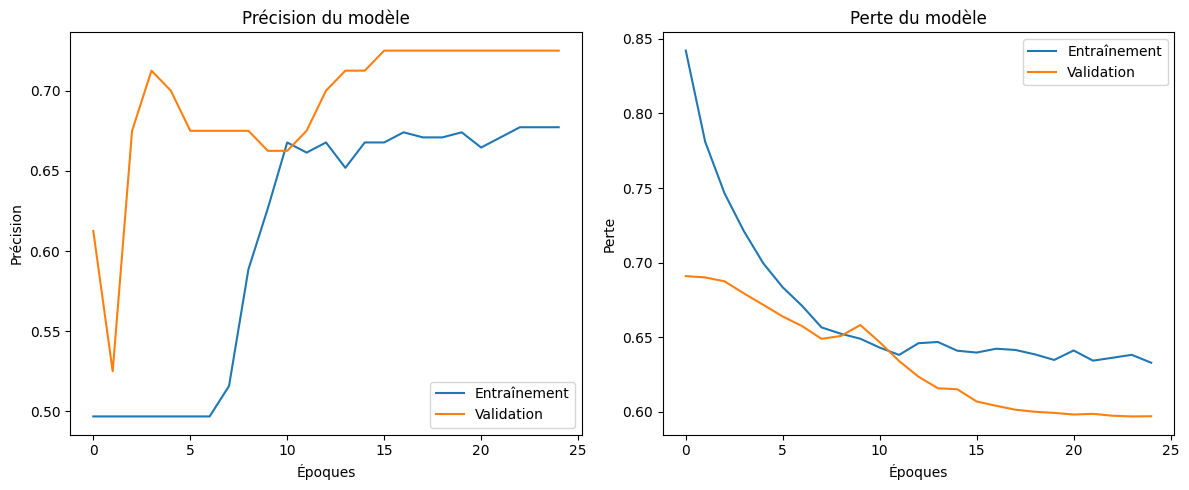

In [20]:
########################
###### Modèle Siamois ######

# 4. Création du modèle Siamese
input_shape = (size_image_y, size_image_x, 1)  # Définition de la forme d’entrée : image en niveaux de gris

import tensorflow.keras.backend as K

# Fonction de perte contrastive, utile pour les modèles siamese (non utilisée ici, mais définie au cas où)
def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Marge maximale autorisée entre deux embeddings de classes différentes
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Fonction pour créer le modèle Siamois
def create_siamese_model(input_shape):
    """Crée et retourne le modèle Siamese."""

    input_img = Input(shape=input_shape)  # Entrée unique du sous-réseau

    # Bloc convolutionnel 1
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Bloc convolutionnel 2
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
"""
    # Bloc convolutionnel 3
    x = layers.Conv2D(24, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
"""
    # GlobalAveragePooling pour obtenir un vecteur compact
    output = keras.layers.GlobalAveragePooling2D()(x)

    # Couche dense (embedding final)
    output = keras.layers.Dense(50, activation="sigmoid")(output)

    # Ajout d’un Dropout
    output = layers.Dropout(0.3)(output)

    # Définition du sous-modèle (appelé pour chaque image)
    siamese = Model(input_img, output, name="siamese")
    siamese.summary()  # Affiche le résumé du modèle

    # Deux entrées pour les deux images à comparer
    input_img_1 = Input(shape=input_shape)
    input_img_2 = Input(shape=input_shape)

    # Encodage des deux images via le même sous-réseau
    encoded_1 = siamese(input_img_1)
    encoded_2 = siamese(input_img_2)

    # Calcul de la distance euclidienne entre les deux encodages
    distance = layers.Lambda(
        lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True))
    )([encoded_1, encoded_2])

    # Sortie finale avec activation sigmoïde pour prédire si les images sont similaires
    output = layers.Dense(1, activation='sigmoid')(distance)

    # Création du modèle Siamois final
    siamese_model = Model(inputs=[input_img_1, input_img_2], outputs=output)
    return siamese_model

# Création du modèle avec la forme d’entrée définie
siamese_model = create_siamese_model(input_shape)

# 6. Compilation et callbacks
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Séparation des paires en deux tableaux (images 1 et 2)
X1 = pairs[:, 0]  # Première image de chaque paire
X2 = pairs[:, 1]  # Deuxième image de chaque paire
y = labels_pairs  # Labels : 1 (même classe) ou 0 (différente)

# Création d’un tableau d’indices pour la division train/validation
indices = np.arange(len(X1))

# Division aléatoire des indices (80% entraînement, 20% validation)
indices_train, indices_val = train_test_split(indices, test_size=0.2, random_state=42)

# Utilisation des indices pour extraire les données
X1_train, X2_train, y_train = X1[indices_train], X2[indices_train], y[indices_train]
X1_val, X2_val, y_val = X1[indices_val], X2[indices_val], y[indices_val]

# Redimensionner toutes les images (au cas où elles ne seraient pas aux bonnes dimensions)
X1_train = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X1_train], dtype=np.float32)
X2_train = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X2_train], dtype=np.float32)
X1_val = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X1_val], dtype=np.float32)
X2_val = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X2_val], dtype=np.float32)

# Reshape des étiquettes pour les adapter à la sortie du modèle
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Vérification des dimensions
assert len(X1_train) == len(X2_train) == len(y_train)
assert len(X1_val) == len(X2_val) == len(y_val)

# Fonction pour convertir les images en niveaux de gris avec canal unique
def convert_to_gray(images):
    gray_images = []
    for img in images:
        if img is None:
            raise ValueError("Erreur : Une image n'a pas été chargée correctement.")

        if len(img.shape) == 2:  # Si image déjà en niveaux de gris (H, W)
            img = np.expand_dims(img, axis=-1)
        elif img.shape[-1] == 3:  # Si image RGB (H, W, 3)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1)

        gray_images.append(img)

    return np.array(gray_images)

# Conversion des ensembles en niveaux de gris
X1_train = convert_to_gray(X1_train)
X2_train = convert_to_gray(X2_train)
X1_val = convert_to_gray(X1_val)
X2_val = convert_to_gray(X2_val)

# Callback pour arrêter l'entraînement si pas d'amélioration
early_stopping = EarlyStopping(
    monitor='val_loss',             # Surveille la perte sur validation
    patience=5,                    # Attend n époques sans amélioration
    restore_best_weights=True,     # Restaure les meilleurs poids
    verbose=1
)

# Callback pour réduire le learning rate si stagnation
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',             # Surveille aussi val_loss
    factor=0.25,                    # Réduction du taux d’apprentissage
    patience=2,                     # Réduit après n époques sans amélioration
    min_lr=1e-6,                    # Limite minimale du learning rate
    verbose=1
)

# Entraînement du modèle Siamois avec validation
history = siamese_model.fit(
    [X1_train, X2_train], y_train, 
    validation_data=([X1_val, X2_val], y_val), 
    epochs=10, 
    batch_size=16, 
    callbacks=[early_stopping, reduce_lr]
)

# Affichage des courbes d'entraînement
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step
🔹 Visualisation paire SIMILAIRE la plus similaire (Label = 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


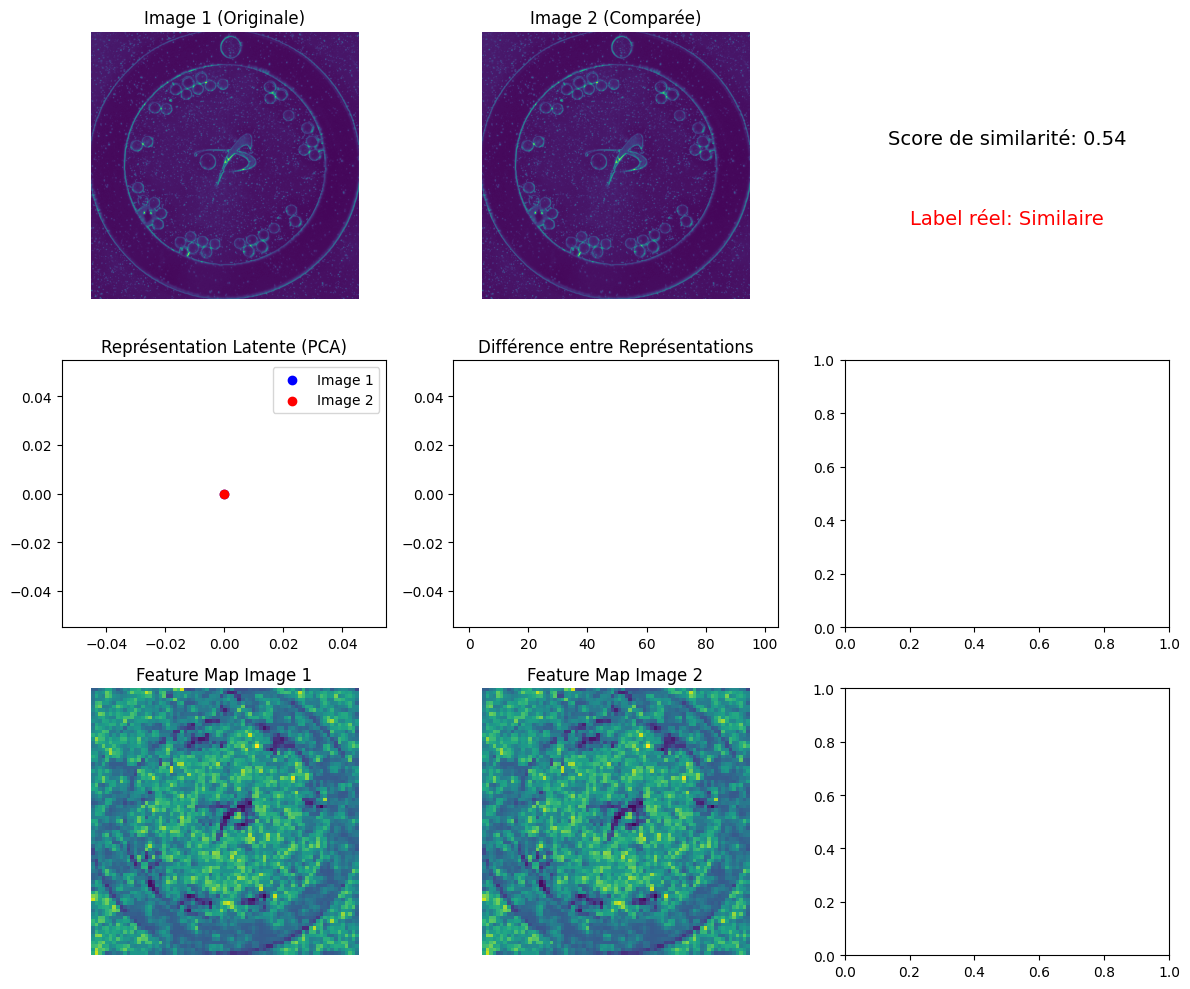

🔹 Visualisation paire SIMILAIRE la moins similaire (Label = 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


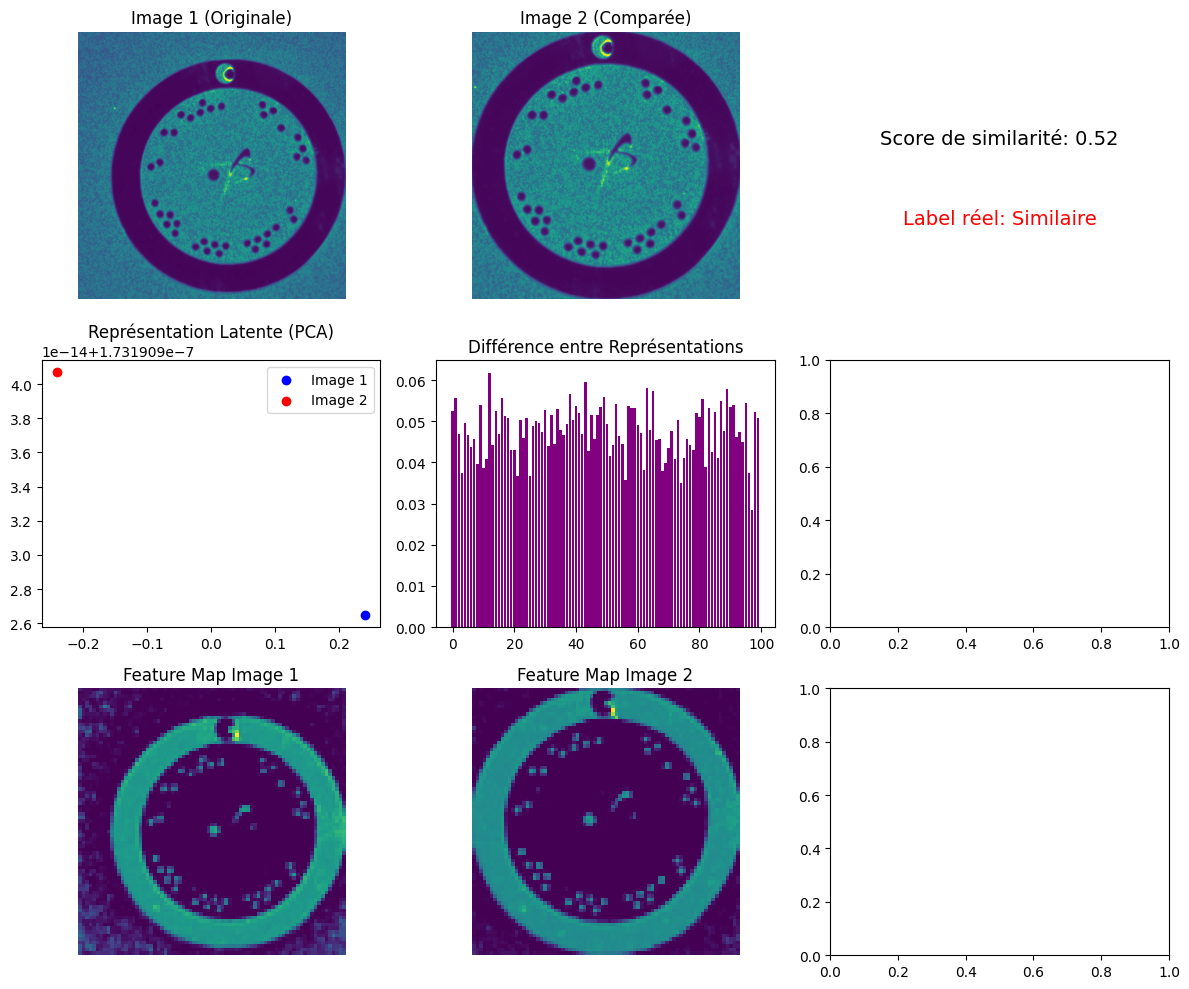

🔹 Visualisation paire DIFFÉRENTE la plus similaire (Label = 0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


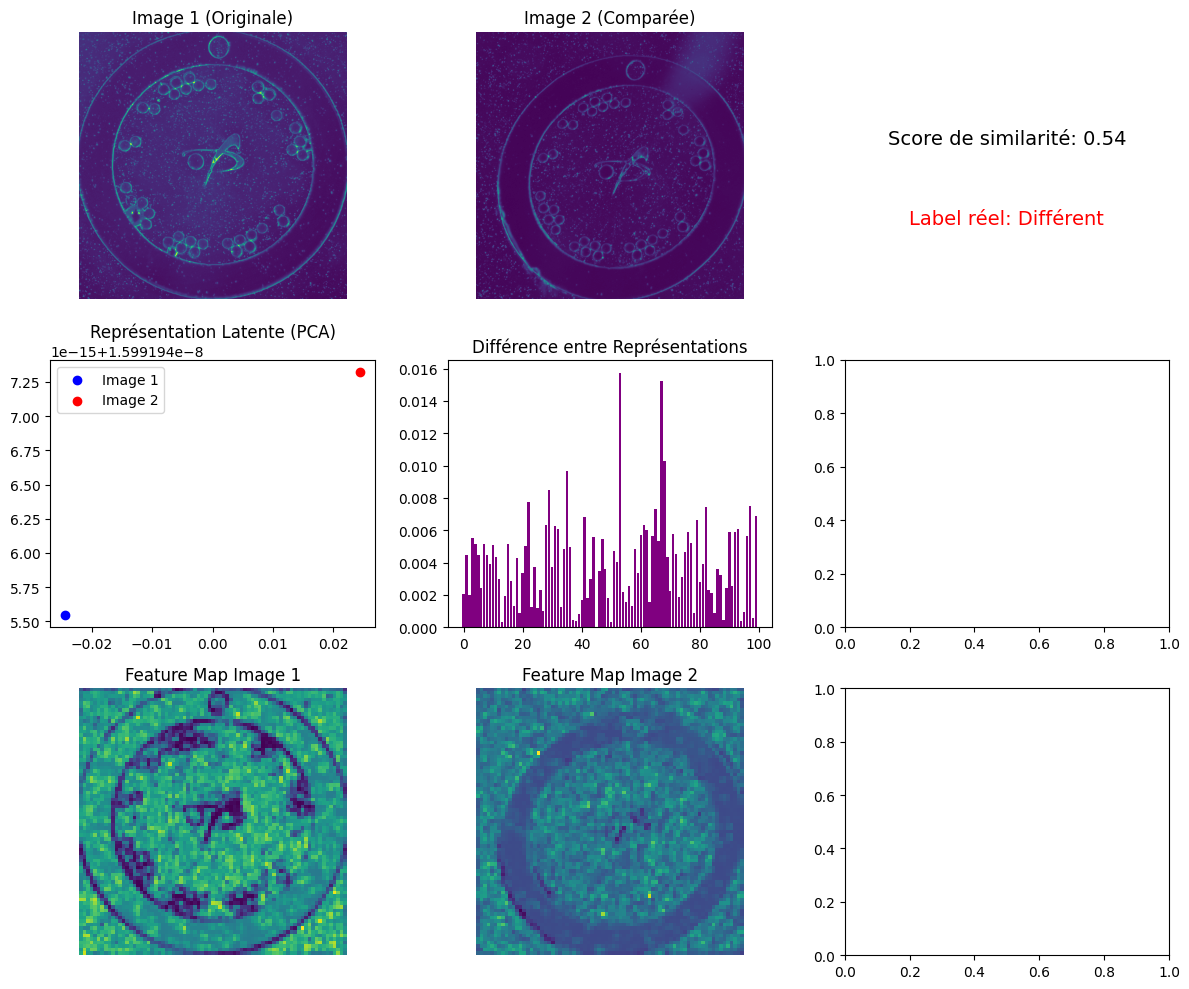

🔹 Visualisation paire DIFFÉRENTE la moins similaire (Label = 0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


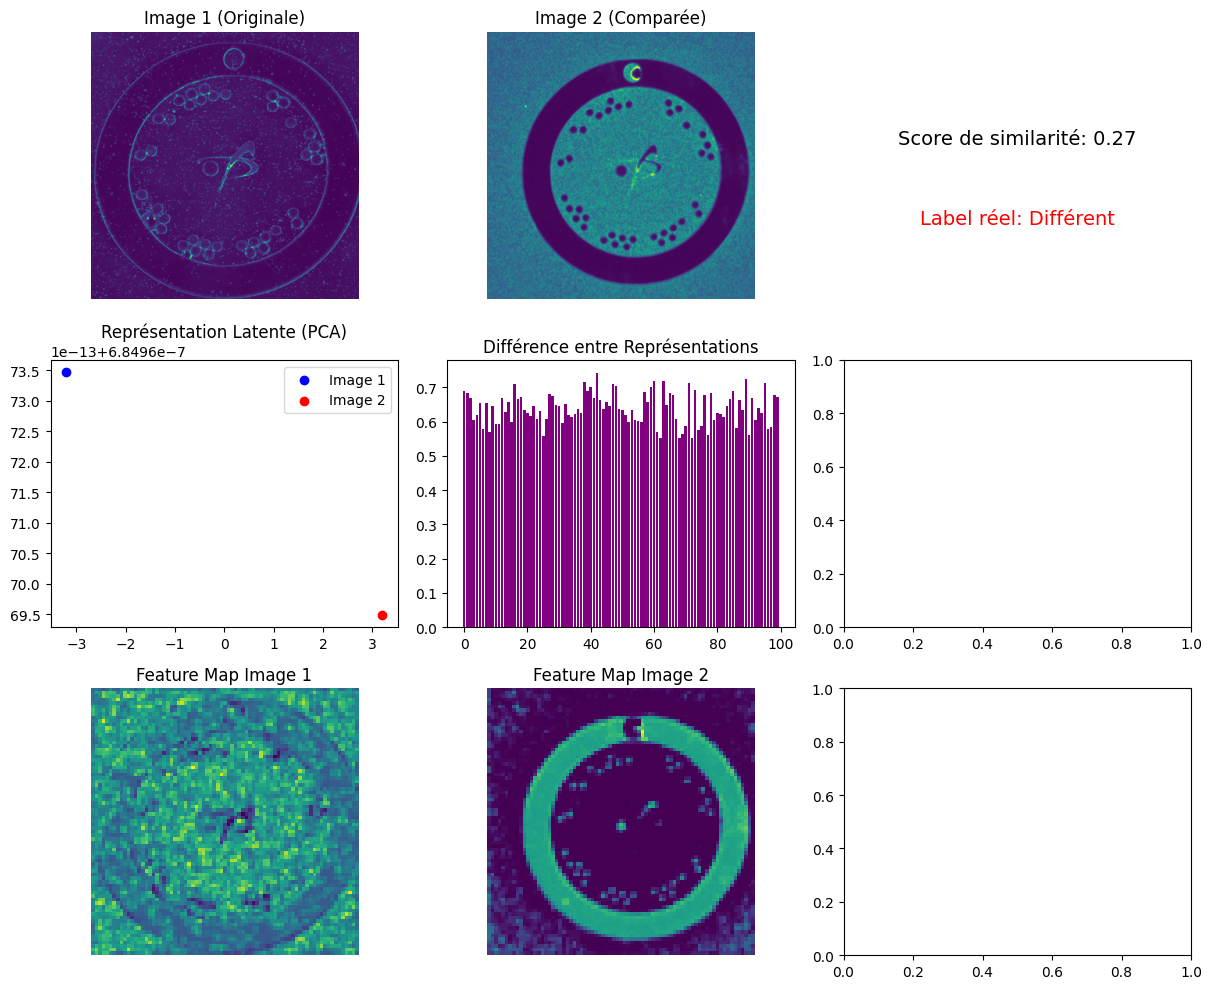

In [21]:
##################################
### test amélioration -> voir avant couche dense

def visualiser_paire(idx, label):
    """Affiche la comparaison pour une paire donnée (idx) dans le jeu de validation."""

    image1 = np.expand_dims(X1_val[idx], axis=0)  # Ajouter une dimension pour le batch à l'image 1
    image2 = np.expand_dims(X2_val[idx], axis=0)  # Ajouter une dimension pour le batch à l'image 2

    # Récupère la sous-partie du modèle Siamese servant d'encodeur
    encoder_siamois = siamese_model.get_layer("siamese")  

    # 🔹 EXTRACTION DES REPRESENTATIONS LATENTES (sorties du Dense)
    latent1 = encoder_siamois.predict(image1)  # Représentation latente de l'image 1
    latent2 = encoder_siamois.predict(image2)  # Représentation latente de l'image 2

    # 🔹 Recherche de la dernière couche convolutionnelle ou de pooling avant GlobalAveragePooling2D
    last_conv_layer = None
    for layer in reversed(encoder_siamois.layers):
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.MaxPooling2D):
            last_conv_layer = layer  # Stocke la dernière couche 2D trouvée
            break

    if last_conv_layer is None:
        raise ValueError("Aucune couche 2D trouvée avant GlobalAveragePooling2D ! Vérifiez l'architecture.")

    # Crée un modèle intermédiaire pour récupérer les sorties de la dernière couche 2D
    model_intermediaire = Model(inputs=encoder_siamois.input, outputs=last_conv_layer.output)
    
    feature_map1 = model_intermediaire.predict(image1)  # Feature maps de l'image 1
    feature_map2 = model_intermediaire.predict(image2)  # Feature maps de l'image 2

    # 🔹 Normalisation des images pour affichage avec imshow (valeurs entre 0 et 1)
    image1_display = np.clip(X1_val[idx] / 255.0, 0, 1)
    image2_display = np.clip(X2_val[idx] / 255.0, 0, 1)

    # Création de la figure pour affichage
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    # 🔹 Affiche les images d'entrée (image 1 et 2)
    axes[0, 0].imshow(image1_display)
    axes[0, 0].axis("off")
    axes[0, 0].set_title("Image 1 (Originale)")

    axes[0, 1].imshow(image2_display)
    axes[0, 1].axis("off")
    axes[0, 1].set_title("Image 2 (Comparée)")

    # 🔹 PCA si possible (si vecteurs latents ont variance > 0)
    if latent1.shape[1] > 2:
        if np.var(latent1) > 0 and np.var(latent2) > 0:
            pca = PCA(n_components=2)
            latent_pca = pca.fit_transform(np.vstack([latent1, latent2]))  # Réduction des dimensions

            axes[1, 0].scatter(latent_pca[0, 0], latent_pca[0, 1], c="blue", label="Image 1")
            axes[1, 0].scatter(latent_pca[1, 0], latent_pca[1, 1], c="red", label="Image 2")
            axes[1, 0].legend()
            axes[1, 0].set_title("Représentation Latente (PCA)")
        else:
            # Si la variance est nulle, affichage d'un message à la place du graphique
            axes[1, 0].text(0.5, 0.5, "Variance nulle (PCA impossible)", ha="center", va="center")
            axes[1, 0].axis("off")
    else:
        # Si vecteurs latents trop petits pour PCA, les tracer sous forme de courbes
        axes[1, 0].plot(latent1.flatten(), label="Image 1", color="blue")
        axes[1, 0].plot(latent2.flatten(), label="Image 2", color="red")
        axes[1, 0].legend()
        axes[1, 0].set_title("Représentation Latente (Vecteur)")

    # 🔹 Affiche la différence absolue entre les deux représentations latentes
    difference = np.abs(latent1 - latent2)
    axes[1, 1].bar(range(len(difference.flatten())), difference.flatten(), color="purple")
    axes[1, 1].set_title("Différence entre Représentations")

    # 🔹 Affiche les feature maps moyennées (image 1 et image 2)
    mean_feature1 = np.mean(feature_map1[0], axis=-1)  # Moyenne sur les canaux (pour affichage 2D)
    mean_feature2 = np.mean(feature_map2[0], axis=-1)

    axes[2, 0].imshow(mean_feature1, cmap="viridis")
    axes[2, 0].set_title("Feature Map Image 1")
    axes[2, 0].axis("off")

    axes[2, 1].imshow(mean_feature2, cmap="viridis")
    axes[2, 1].set_title("Feature Map Image 2")
    axes[2, 1].axis("off")

    # 🔹 Prédit la similarité avec le modèle Siamese et affiche score et label réel
    similarity_score = siamese_model.predict([image1, image2])[0, 0]
    label_str = "Similaire" if label == 1 else "Différent"
    
    axes[0, 2].text(0.5, 0.6, f"Score de similarité: {similarity_score:.2f}", fontsize=14, ha="center", va="center")
    axes[0, 2].text(0.5, 0.3, f"Label réel: {label_str}", fontsize=14, color="red", ha="center", va="center")
    axes[0, 2].axis("off")

    plt.tight_layout()
    plt.show()


# 🔍 Prédictions sur l'ensemble de validation pour toutes les paires
similarity_scores = siamese_model.predict([X1_val, X2_val]).flatten()

# 🔹 Sélection des indices pour les paires similaires (label = 1)
similar_indices = np.where(y_val == 1)[0]
similar_scores = similarity_scores[similar_indices]
idx_similaire_max_similaires = similar_indices[np.argmax(similar_scores)]  # Paire la plus similaire parmi les vraies similaires
print("🔹 Visualisation paire SIMILAIRE la plus similaire (Label = 1)")
visualiser_paire(idx_similaire_max_similaires, 1)

idx_similaire_min_similaires = similar_indices[np.argmin(similar_scores)]  # Paire la moins similaire parmi les vraies similaires
print("🔹 Visualisation paire SIMILAIRE la moins similaire (Label = 1)")
visualiser_paire(idx_similaire_min_similaires, 1)

# 🔹 Sélection des indices pour les paires différentes (label = 0)
different_indices = np.where(y_val == 0)[0]
different_scores = similarity_scores[different_indices]
idx_different_max_differents = different_indices[np.argmax(different_scores)]   # Paire différente avec score le plus élevé (faux positif)
print("🔹 Visualisation paire DIFFÉRENTE la plus similaire (Label = 0)")
visualiser_paire(idx_different_max_differents, 0)

idx_different_min_differents = different_indices[np.argmin(different_scores)]   # Paire différente avec score le plus faible (vrai négatif)
print("🔹 Visualisation paire DIFFÉRENTE la moins similaire (Label = 0)")
visualiser_paire(idx_different_min_differents, 0)


Fichiers dans le dossier : ['classe1', 'classe2', 'classe3', 'classe4', 'classe5']
5 images originales chargées.
Fichiers chargés : ['C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe1\\originale.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe2\\Extime643.9ms-gain3.2x-5X- red267_4807.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe3\\Extime643.9ms-gain3.2x-5X- red267_4779.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe4\\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4849.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe5\\8s-gain 1x-5X-red2.43-bleu10contrast 1_5297.jpg']
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\test\Chien.jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\test\classe1_modifiee (5).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\t

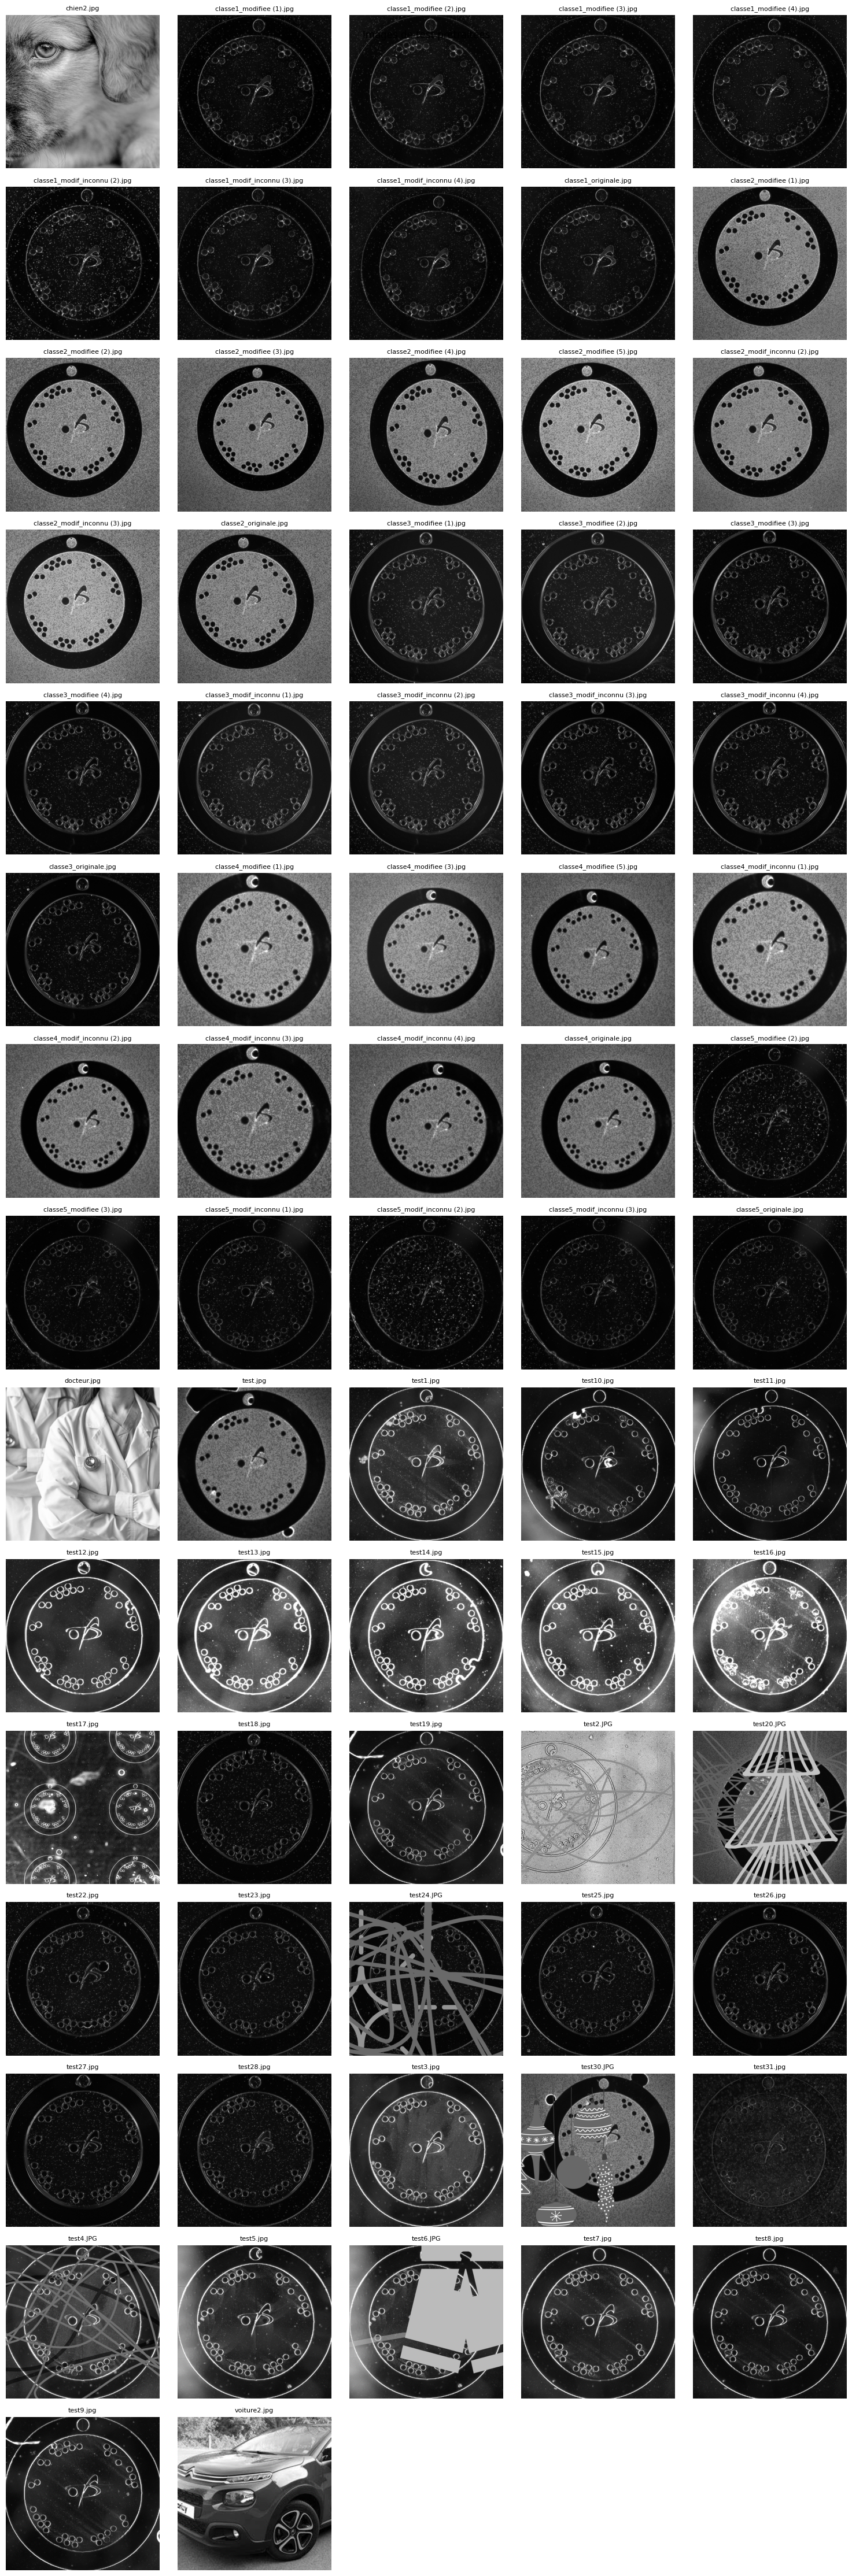

In [22]:
################################
####### Chargement données de test ######

# Dimensions pour le redimensionnement lors de la détection de cercle
resize_width, resize_height = 480, 256

def cropped_and_gray_image(img_path):
    """Charge une image, détecte un cercle, recadre autour et la convertit en niveaux de gris."""
    
    image0 = cv2.imread(img_path)  # Charger l'image d'origine

    if image0 is None:
        print(f"Erreur : Impossible de charger {img_path}")
        return None  # Retourner None si l'image est illisible

    # Redimensionner l'image pour faciliter la détection de cercles
    image = cv2.resize(image0, (resize_width, resize_height))

    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Détection de cercles avec HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300, param1=100, param2=10, minRadius=100, maxRadius=200)

    # Calcul du centre de l'image
    height, width = gray.shape
    center_x, center_y = width // 2, height // 2

    best_circle = None  # Initialisation de la meilleure détection
    min_distance = float("inf")  # Initialisation de la distance minimale

    # Si des cercles sont détectés
    if circles is not None:
        for circle in circles[0, :]:
            x, y, r = circle  # Coordonnées et rayon du cercle

            # Vérifier que le cercle est totalement à l'intérieur de l'image
            if (x - r >= 0 and y - r >= 0 and x + r <= width and y + r <= height):
                distance_to_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if distance_to_center < min_distance:
                    min_distance = distance_to_center
                    best_circle = circle  # Mise à jour du meilleur cercle

    # Si un cercle valide a été détecté
    if best_circle is not None:
        x, y, r = best_circle  # Coordonnées et rayon du cercle détecté

        # Mise à l'échelle vers les dimensions de l'image d'origine
        scale_x = image0.shape[1] / resize_width
        scale_y = image0.shape[0] / resize_height
        x = int(x * scale_x)
        y = int(y * scale_y)
        r = int(r * min(scale_x, scale_y))  # Échelle uniforme pour le rayon

        side = 2 * r  # Côté du carré à extraire

        # Définition des coordonnées du carré autour du cercle
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r

        # S'assurer que le carré reste dans les limites de l'image
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image0.shape[1], x2), min(image0.shape[0], y2)

        cropped_image = image0[y1:y2, x1:x2]  # Recadrage

        # Conversion en niveaux de gris
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return cropped_gray
    else:
        print(f"Aucun cercle trouvé pour: {img_path}")
        return None  # Aucun cercle détecté, retour de None

def load_and_preprocess_test_images(load_dir, size_image_x, size_image_y):
    """Charge, recadre et prétraite les images de test en niveaux de gris."""
    
    test_images = []  # Stocke les tableaux d'images
    valid_file_names = []  # Stocke les noms des fichiers valides
    
    # Liste des fichiers d'image valides dans le dossier
    test_image_files = [f for f in os.listdir(load_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in test_image_files:
        img_path = os.path.join(load_dir, file)
        try:
            img = cropped_and_gray_image(img_path)  # Chargement et recadrage

            if img is not None:
                img_resized = Image.fromarray(img).resize((size_image_x, size_image_y))  # Redimensionner
                img_array = np.array(img_resized) / 255.0  # Normalisation [0,1]
                test_images.append(img_array)
                valid_file_names.append(file)  # Ajouter le nom si image valide

        except Exception as e:
            print(f"❌ Erreur avec l'image {file}: {e}")

    if len(test_images) == 0:
        raise ValueError("❌ Aucune image de test chargée. Vérifiez le dossier des images de test.")

    return np.array(test_images), valid_file_names  # Retour des images et noms valides

def load_and_preprocess_original_images(base_dir, size_image_x, size_image_y):
    """Charge toutes les images des sous-dossiers de base_dir et les prétraite."""

    images = []  # Stockage des images traitées
    image_files = []  # Stockage des chemins des fichiers

    # Liste de tous les fichiers images dans le dossier de base
    base_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)

        # Vérifier que le chemin est bien un dossier (classe)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)

                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        img = Image.open(file_path).convert("L")  # Conversion en niveaux de gris
                        img_resized = img.resize((size_image_x, size_image_y))  # Redimensionner
                        img_array = np.array(img_resized) / 255.0  # Normaliser

                        images.append(img_array)
                        image_files.append(file_path)  # Chemin complet

                    except Exception as e:
                        print(f"❌ Erreur avec l'image {file_name}: {e}")

    if len(images) == 0:
        raise ValueError("Aucune image originale chargée. Vérifiez le dossier des images originales.")

    return np.array(images), image_files

# Affiche les fichiers présents dans le dossier des images originales
print("Fichiers dans le dossier :", os.listdir(og_dir))

# Chargement des images originales prétraitées
base_array, base_files = load_and_preprocess_original_images(og_dir, size_image_x, size_image_y)

print(f"{len(base_array)} images originales chargées.")
print("Fichiers chargés :", base_files)

# Chargement des images de test
test_images, test_image_files = load_and_preprocess_test_images(test_dir, size_image_x, size_image_y)
print("Test modèle siamois chargé !")

def show_images(images, file_names, title, cols=5):
    """Affiche les images dans une grille avec titres."""
    
    num_images = len(images)
    rows = math.ceil(num_images / cols)  # Calcul du nombre de lignes nécessaires

    plt.figure(figsize=(cols * 3, rows * 3))  # Taille proportionnelle à la grille
    
    for i, (image, file_name) in enumerate(zip(images, file_names)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap="gray")  # Affichage des images en niveaux de gris
        plt.title(file_name, fontsize=8)  # Titre : nom du fichier
        plt.axis("off")  # Masquer les axes

    plt.suptitle(title, fontsize=12)  # Titre général de la figure
    plt.tight_layout()
    plt.show()

# Affiche les images de test avec une disposition lisible
show_images(test_images, test_image_files, "Images de test prétraitées")


In [25]:
####### Similarités modèles siamois (Conparaison image par image) ######
name = []
for filename in os.listdir(test_dir):
    name.append(filename)
def comparer_images(image1, image2):
    """Compare deux images avec le modèle siamois et retourne un score de similarité."""
    # Assurez-vous que l'image est bien un tableau NumPy avec la bonne forme
    image1 = np.expand_dims(image1, axis=0)  # (1, hauteur, largeur, canaux)
    image2 = np.expand_dims(image2, axis=0)  

    # Vérification des dimensions avant d'envoyer au modèle
    #print(f"✅ Forme image1 : {image1.shape}, image2 : {image2.shape}")

    # Passage dans le modèle
    try:
        prediction = siamese_model.predict([image1, image2])
        similarity_score = float(np.mean(prediction))
        return similarity_score
    except Exception as e:
        print(f"❌ Erreur dans la prédiction : {e}")
        return 0.0  # Retourner un score bas en cas d'erreur

# Parcours des images test
for file in test_image_files:
    img_path = os.path.join(test_dir, file)
    try:
        # Charger l'image en niveaux de gris
        image_test = Image.open(img_path).convert("L")  # Convertir en niveaux de gris
        image_test = image_test.resize((size_image_x, size_image_y))  # Redimensionner
        img_array = np.array(image_test, dtype=np.float32) / 255.0  # Normalisation
        
        # Ajouter une dimension de canal pour compatibilité modèle (hauteur, largeur, 1)
        img_array = np.expand_dims(img_array, axis=-1)  

        # Comparer avec chaque image originale
        for i, img_orig in enumerate(base_array):
            img_orig_exp = np.expand_dims(img_orig, axis=-1)  # S'assurer du bon format
            similarity = comparer_images(img_orig_exp, img_array)

            # Déterminer si la correspondance est vraie ou fausse
            statut = "Vrai" if similarity > 0.6 else "Faux"
            print(f"{file}: Similarité avec og {i+1} = {similarity:.4f} - {statut}")

    except Exception as e:
        print(f"❌ Erreur lors du chargement de l'image {file}: {e}")

# Sauvegarde du modèle
siamese_model.save("siamese_model.keras")
print("✅ Modèle sauvegardé.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
chien2.jpg: Similarité avec og 1 = 0.5090 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
chien2.jpg: Similarité avec og 2 = 0.5079 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
chien2.jpg: Similarité avec og 3 = 0.5025 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
chien2.jpg: Similarité avec og 4 = 0.5090 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
chien2.jpg: Similarité avec og 5 = 0.5020 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
chien2.jpg: Similarité avec og 6 = 0.5096 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
chien2.jpg: Similarité avec og 7 = 0.5098 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
chien2.jpg: Similarité avec og 8 = 0.5041 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
chien2.jpg: Similarité avec og 9 = 0.5018 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
chien2.jpg: Similarité avec og 10 = 0.5023 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
classe1 (2).jpg: Similarité avec og 1 = 0.4953 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/st

KeyboardInterrupt: 


--- Phase de Test avec enregistrement pour graphe ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
✅ chien2.jpg → Vraie classe: 0, Prédit: 2, score: 0.4779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
✅ classe1_modifiee (1).jpg → Vraie classe: 1, Prédit: 1, score: 0.5369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
✅ classe1_modifiee (2).jpg → Vraie classe: 1, Prédit: 1, score: 0.5358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━

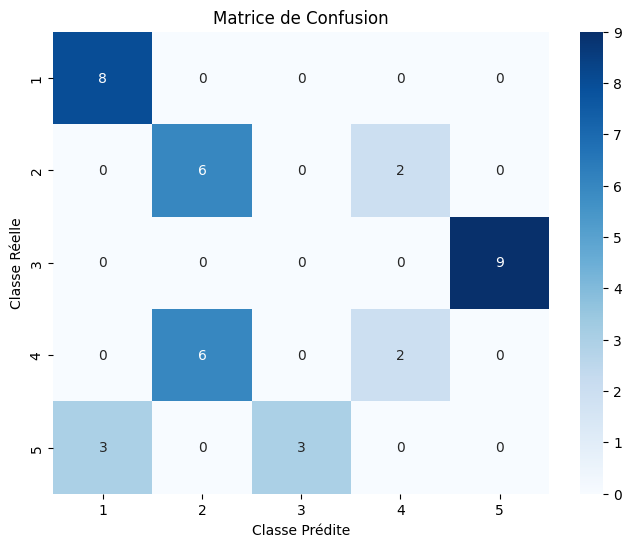

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

####### Similarités modèles siamois (Comparaison image par image) ######

def comparer_images(image1, image2):
    """Compare deux images avec le modèle siamois et retourne un score de similarité."""
    # Ajouter une dimension pour former (1, H, W, C), conforme à l'entrée du modèle
    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)

    # Tenter la prédiction avec le modèle siamois
    try:
        prediction = siamese_model.predict([image1, image2])  # Prédiction entre deux images
        similarity_score = float(np.mean(prediction))  # Moyenne du score de sortie
        return similarity_score
    except Exception as e:
        print(f"❌ Erreur dans la prédiction : {e}")
        return 0.0  # Score par défaut en cas d'échec

def trouver_meilleure_correspondance(test_image, base_array):
    """Trouve la meilleure correspondance (plus grande similarité) entre une image de test et la base."""
    meilleure_similarite = 0
    meilleure_classe = "Inconnue"  # Valeur par défaut

    for i, img_orig in enumerate(base_array):
        img_orig = np.expand_dims(img_orig, axis=-1)  # Ajout d’un canal pour images en niveaux de gris

        try:
            similarity_score = comparer_images(img_orig, test_image)  # Score de similarité
        except Exception as e:
            print(f"❌ Erreur dans la comparaison : {e}")
            similarity_score = 0

        # Met à jour la meilleure similarité si une meilleure est trouvée
        if similarity_score > meilleure_similarite:
            meilleure_similarite = similarity_score
            meilleure_classe = i + 1  # Optionnel : utiliser base_files[i] pour afficher le nom du fichier

    return meilleure_classe, meilleure_similarite

def extraire_classe(filename):
    """Extrait la classe à partir du nom du fichier (suppose une structure contenant 'classeX')."""
    for i in range(1, 10):  # Adapter cette plage selon les classes réelles
        if f"classe{i}" in filename.lower():
            return i
    return 0  # Retourne 0 si la classe n'est pas détectée

# Initialisation des listes pour les vraies classes et les prédictions
true_labels = []
predicted_labels = []

print("\n--- Phase de Test avec enregistrement pour graphe ---")

# Boucle sur chaque image de test
for img_array, filename in zip(test_images, test_image_files):
    try:
        img_array = np.expand_dims(img_array, axis=-1)  # Ajout du canal pour correspondre au modèle

        true_class = extraire_classe(filename)  # Extraction de la vraie classe
        meilleure_classe, score = trouver_meilleure_correspondance(img_array, base_array)  # Prédiction

        true_labels.append(true_class)
        predicted_labels.append(meilleure_classe)

        print(f"✅ {filename} → Vraie classe: {true_class}, Prédit: {meilleure_classe}, score: {score:.4f}")
    except Exception as e:
        print(f"❌ Erreur pour {filename}: {e}")

# Conversion en tableaux NumPy pour manipulation
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Masquage des entrées invalides (classe = 0 signifie erreur ou classe inconnue)
mask = (true_labels_np != 0) & (predicted_labels_np != 0)
true_labels_filtered = true_labels_np[mask]
predicted_labels_filtered = predicted_labels_np[mask]

# Création de la matrice de confusion uniquement sur les classes valides
labels_unique = sorted(set(true_labels_filtered))
cm = confusion_matrix(true_labels_filtered, predicted_labels_filtered, labels=labels_unique)

# Visualisation avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step


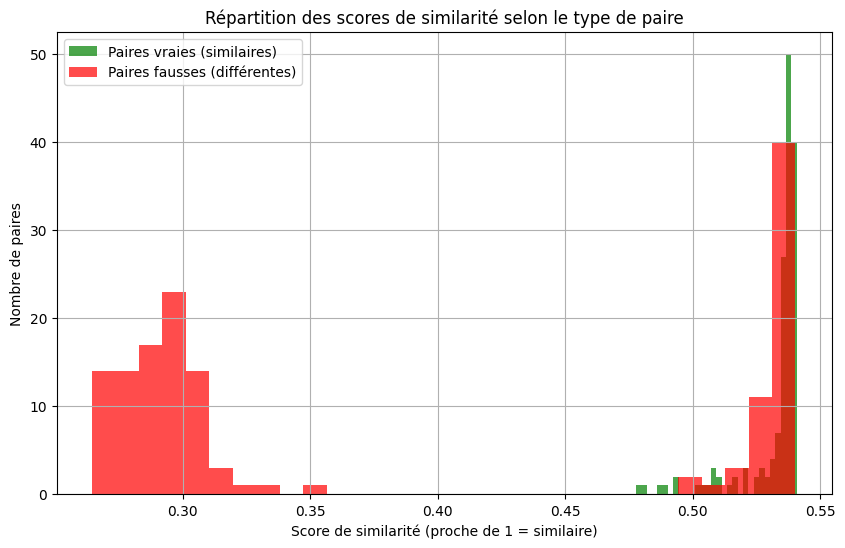

In [24]:
# ÉTAPE DE VÉRIFICATION : Histogramme des similarités

# Sélection d’un sous-ensemble aléatoire de paires pour analyser les performances
num_samples = 300  # Nombre de paires à évaluer (à adapter selon taille mémoire et temps)
sample_indices = np.random.choice(len(X1_train), size=num_samples, replace=False)

# Extraction des paires sélectionnées et de leurs labels
X1_sample = X1_train[sample_indices]
X2_sample = X2_train[sample_indices]
y_sample = y_train[sample_indices]

# Prédiction des scores de similarité par le modèle siamois
similarity_scores = siamese_model.predict([X1_sample, X2_sample])  # Résultat : tableau de scores

# Aplatir les scores pour traitement facile (forme initiale : (N, 1))
similarity_scores = similarity_scores.flatten()

# Séparer les scores selon qu’il s’agisse de vraies ou fausses paires
true_pairs_scores = similarity_scores[y_sample.flatten() == 1]   # Paires similaires (positives)
false_pairs_scores = similarity_scores[y_sample.flatten() == 0]  # Paires différentes (négatives)

# Tracer un histogramme pour visualiser la distribution des similarités
plt.figure(figsize=(10, 6))  # Taille de la figure

# Histogramme pour les vraies paires (doit idéalement se concentrer vers 1)
plt.hist(true_pairs_scores, bins=30, alpha=0.7, label='Paires vraies (similaires)', color='green')

# Histogramme pour les fausses paires (doit idéalement se concentrer vers 0)
plt.hist(false_pairs_scores, bins=30, alpha=0.7, label='Paires fausses (différentes)', color='red')

# Ajout des titres et légendes
plt.title("Répartition des scores de similarité selon le type de paire")
plt.xlabel("Score de similarité (proche de 1 = similaire)")
plt.ylabel("Nombre de paires")
plt.legend()
plt.grid(True)  # Grille pour lecture visuelle plus facile
plt.show()  # Affichage final
